<a href="https://colab.research.google.com/github/Dedulus/Dedulus/blob/main/VAE_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:


import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as k
import matplotlib.pyplot as plt


from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from importlib import reload




In [3]:
!nvidia-smi

Sat Jul 23 14:48:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |    284MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
BATCH_SIZE = 128
LATENT_DIM = 10
SIZE = 28
NUM_CHANNELS = 1
LR = 0.0001
BETA = 1.
GAMMA = 1.

In [5]:
### loading mnist data
(train_images, y_train), (test_images, y_test) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape((-1,28,28,1)).astype('float32')
test_images = test_images.reshape((-1,28,28,1)).astype('float32')
train_images /= 255.
test_images /= 255.

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(1000).batch(BATCH_SIZE)

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as k

def make_model(SIZE=28, LATENT_DIM=10, BETA=1., GAMMA=1.):

    def sample(inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch, LATENT_DIM))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    # Encoder
    encoder_inputs = layers.Input(shape=(SIZE, SIZE, 1), name='encoder_input')
    e = layers.Conv2D(filters=8,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(encoder_inputs)
    e = layers.BatchNormalization()(e)
    e = layers.Conv2D(filters=16,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(e)
    e = layers.BatchNormalization()(e)
    e = layers.Flatten()(e)
    z_mean = layers.Dense(LATENT_DIM, name='z_mean')(e)
    z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(e)
    encoder = k.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var], name='encoder')
    
    
    # Decoder
    decoder_inputs = layers.Input(shape=(LATENT_DIM,), name='decoder_input')
    d = layers.Dense(units=7*7*8,activation='relu')(decoder_inputs)
    d = layers.Reshape((7,7,8))(d)
    d = layers.Conv2DTranspose(filters=16,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    d = layers.Conv2DTranspose(filters=32,kernel_size=4,strides=(2, 2), padding="SAME", activation='relu')(d)
    decoded = layers.Conv2DTranspose(filters=1, kernel_size=3,strides=(1, 1), padding="SAME")(d)
    decoder = k.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')
    
    
    # GAN Discriminator
    discriminator_input = layers.Input(shape=(SIZE, SIZE, 1), name='discriminator_input')
    p = layers.Conv2D(filters=8,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(discriminator_input)
    p = layers.BatchNormalization()(p)
    p = layers.Conv2D(filters=16,kernel_size=5,padding='SAME',activation='relu',strides=(2,2))(p)
    p = layers.BatchNormalization()(p)
    p = layers.Flatten()(p)
    out = layers.Dense(1, name='discriminator_out')(p)
    discriminator = k.Model(inputs=discriminator_input, outputs=[out,p] , name='discriminator')
    
    
    sampler = layers.Lambda(sample)
    vae = k.Model(inputs=encoder_inputs, outputs=decoder(sampler([z_mean, z_log_var])), name='vae')

    
    def log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)
    
    
    def calculate_loss(x):
        z_p = tf.random.normal(shape=(tf.shape(x)[0],LATENT_DIM))
        z_mean, z_log_var = encoder(x)
        z = sample([z_mean, z_log_var])
        out = decoder(z)
        x_p = decoder(z_p)
        dis_x_p, dis_x_p_feat = discriminator(x_p)
        dis_x, dis_x_feat = discriminator(x)
        dis_x_tilde , dis_x_tilde_feat = discriminator(out)

        # kl loss
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, z_mean, z_log_var)
        kl_loss = tf.reduce_mean(logqz_x - logpz)

        
        # gaussian perceptual loss as reconstruction loss
        reconstruction_loss = -tf.reduce_mean(log_normal_pdf(dis_x_feat, dis_x_tilde_feat, tf.zeros_like(dis_x_tilde_feat)))
        

        # gan loss
        cross_entropy = k.losses.BinaryCrossentropy(from_logits=True)
        g_fake = cross_entropy(tf.ones_like(dis_x_tilde), dis_x_tilde)
        g_fake_p = cross_entropy(tf.ones_like(dis_x_p), dis_x_p)
        d_real = cross_entropy(tf.ones_like(dis_x), dis_x)
        d_fake = cross_entropy(tf.zeros_like(dis_x_tilde), dis_x_tilde)
        d_fake_p = cross_entropy(tf.zeros_like(dis_x_p), dis_x_p)

        return BETA*kl_loss , GAMMA*reconstruction_loss , g_fake + g_fake_p, d_fake + d_fake_p + d_real
        
    
    def feed(x, encoder, decoder, discriminator, optimizer):
    
        with tf.GradientTape(persistent=True) as tape:
            l_kl, l_rec, l_gen, l_dis = calculate_loss(x)
            l_enc = l_kl + l_rec
            l_dec = l_rec + l_gen

        enc_grads = tape.gradient(l_enc, encoder.trainable_variables)
        optimizer.apply_gradients(zip(enc_grads, encoder.trainable_variables))

        dec_grads = tape.gradient(l_dec, decoder.trainable_variables)
        optimizer.apply_gradients(zip(dec_grads, decoder.trainable_variables))

        dis_grads = tape.gradient(l_dis, discriminator.trainable_variables)
        optimizer.apply_gradients(zip(dis_grads, discriminator.trainable_variables))

        return l_kl.numpy(), l_rec.numpy(), l_gen.numpy(), l_dis.numpy()


    def train(x, encoder, decoder, discriminator, optimizer):
        l_kl, l_rec, l_gen, l_dis = 0., 0., 0., 0.
        n = 0
        for train_x in x:
            a, b, c, d = feed(train_x, encoder, decoder, discriminator, optimizer)
            l_kl += a
            l_rec += b
            l_gen += c
            l_dis += d
            n += 1
        
        return l_kl / n, l_rec / n, l_gen / n, l_dis / n
    
    
    return encoder, decoder, discriminator, vae, train

In [7]:
encoder, decoder, discriminator, vae, train = make_model()
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 8)    208         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 16)     3216        ['batch_normalization[0][0]']  

In [8]:
for epoch in tqdm(range(30)):
    l = train(train_dataset, encoder, decoder, discriminator, k.optimizers.Adam(1e-4))
    if (epoch+1) % 1 == 0:
        print('\n'+'kl_loss:', l[0], 'rec_loss:', l[1], 'gen_loss:', l[2], 'dis_loss:', l[3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/30 [00:00<?, ?it/s]


kl_loss: 3.3193389805141034 rec_loss: 740.6876444542078 gen_loss: 2.6157553595012186 dis_loss: 1.3895711499744896

kl_loss: 9.369007594549833 rec_loss: 749.9792312589535 gen_loss: 3.4548508571917567 dis_loss: 1.0450295500917983

kl_loss: 11.770656880539363 rec_loss: 748.6171316704008 gen_loss: 3.3956381329087053 dis_loss: 1.3916471129033103

kl_loss: 13.775984849502791 rec_loss: 753.6142165584605 gen_loss: 4.420873210374226 dis_loss: 0.7024144145217277

kl_loss: 17.064535387035118 rec_loss: 764.9458081991688 gen_loss: 5.253953963200421 dis_loss: 0.5530623372302634

kl_loss: 19.562286629097294 rec_loss: 774.9264687739455 gen_loss: 5.707812194376866 dis_loss: 0.4727287457060458

kl_loss: 21.490689165810785 rec_loss: 786.6692359127215 gen_loss: 6.34216011002628 dis_loss: 0.3724137274568269

kl_loss: 22.894925916627017 rec_loss: 798.3626571037114 gen_loss: 6.911695771125842 dis_loss: 0.3036499680486569

kl_loss: 23.971029415821977 rec_loss: 808.7120503179555 gen_loss: 7.334560827405722 di

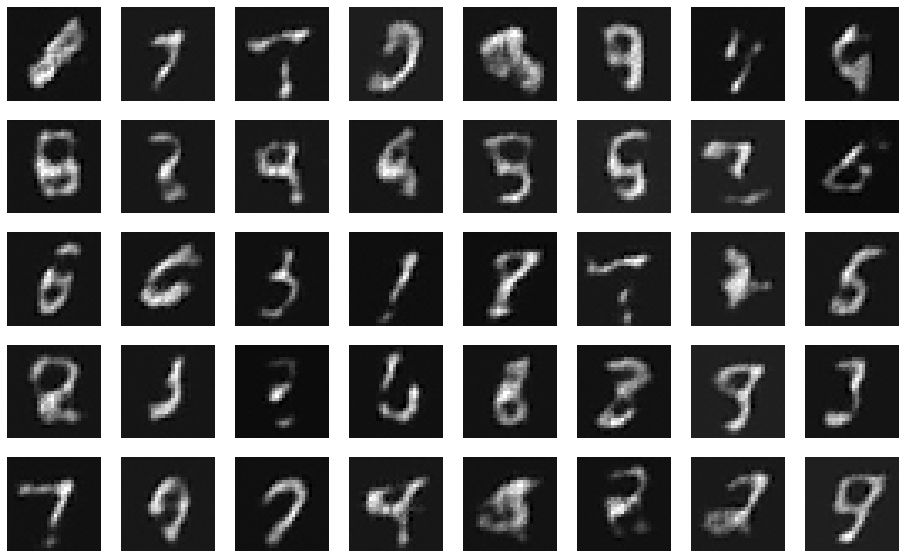

In [10]:
m, n = 5,8
preds = decoder.predict(np.random.normal(size=(m*n,LATENT_DIM)))
plt.figure(figsize=(n*2, m*2))
for i in range(m*n):
    plt.subplot(m, n,i +1)
    plt.imshow(preds[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()